# A/B Test Implementation: Effect of Advertisement on Toy Sales

This notebook conducts an A/B test to evaluate if displaying an ad at a store entrance increases toy sales. It uses synthetic data to simulate sales with and without ads and applies statistical tests to draw conclusions.

## Scenario Summary
- 20 days initial test (10 days with ad, 10 without)
- Sample size check suggests increasing to 60 days per group
- Use t-tests to test hypothesis that ads increase sales
- Perform economic analysis based on sales lift and ad cost


In [1]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import pingouin as pg


## Generate initial sales data for 20 days (10 days each group)
Randomly generate sales data simulating normal distributions with different means and std deviations.

In [2]:
np.random.seed(11)
size = 10
df = pd.DataFrame(data={
    'Sales_wout_ad': np.random.normal(loc=27, scale=5, size=size),
    'Sales_with_ad': np.random.normal(loc=31, scale=10, size=size)
})
df['Differences in sales'] = df['Sales_with_ad'] - df['Sales_wout_ad']
print(df.describe())

# Check normality
pg.normality(data=df, alpha=0.05)

       Sales_wout_ad  Sales_with_ad  Differences in sales
count      10.000000      10.000000             10.000000
mean       25.565902      30.060827              4.494926
std         5.626612       9.523238             12.171660
min        13.733407      17.944515            -13.609670
25%        24.381933      22.644586             -4.029189
50%        25.485739      28.465957              2.038772
75%        28.172404      37.575598             13.868553
max        35.747274      46.746341             22.878515


,W,pval,normal
Sales_wout_ad,0.931026,0.458063,True
Sales_with_ad,0.941080,0.565094,True
Differences in sales,0.954641,0.723471,True


## Plot histograms and boxplots to visualize sales distributions

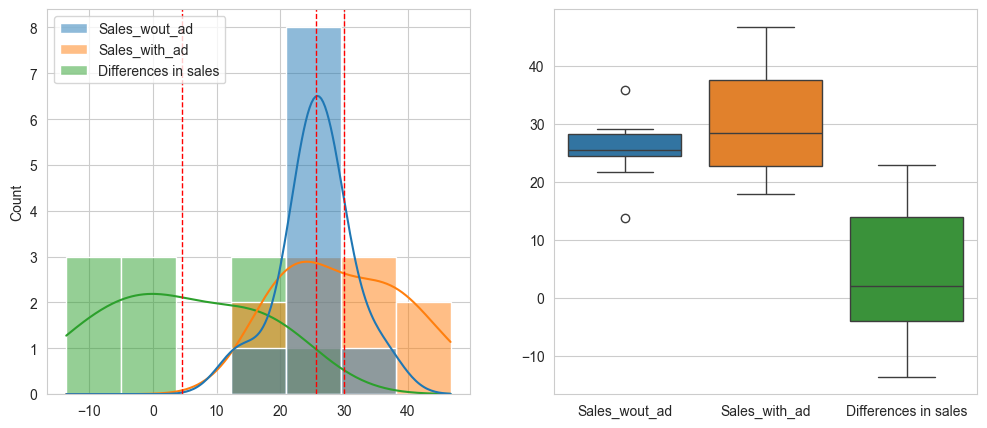

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.histplot(data=df, kde=True, ax=axes[0])
for col in df.columns:
    axes[0].axvline(df[col].mean(), color='r', linestyle='dashed', linewidth=1)
sns.boxplot(data=df, ax=axes[1])
plt.show()

## Sample size calculation for differences in sales
Using the rule of thumb:
\[ N \approx 8 \times \frac{\sigma^2}{d^2} \]

In [4]:
print('Differences in sales describe:')
print(df['Differences in sales'].describe())

sigma = df['Differences in sales'].std()
d = df['Differences in sales'].mean()
N_minimal = 8 * (sigma ** 2) / (d ** 2)
print(f"Minimum required sample size per group: {N_minimal:.2f}")

Differences in sales describe:
count    10.000000
mean      4.494926
std      12.171660
min     -13.609670
25%      -4.029189
50%       2.038772
75%      13.868553
max      22.878515
Name: Differences in sales, dtype: float64
Minimum required sample size per group: 58.66


## Generate extended data for 120 days (60 days per group) to meet sample size requirement

In [5]:
np.random.seed(11)
size = 60
df = pd.DataFrame(data={
    'Sales_wout_ad': np.random.normal(loc=27, scale=5, size=size),
    'Sales_with_ad': np.random.normal(loc=31, scale=10, size=size)
})
df['Differences in sales'] = df['Sales_with_ad'] - df['Sales_wout_ad']
print(df.describe())

# Check normality
pg.normality(data=df, alpha=0.05)

       Sales_wout_ad  Sales_with_ad  Differences in sales
count      60.000000      60.000000             60.000000
mean       26.966991      31.884004              4.917012
std         4.415282      10.658547             12.017531
min        13.733407      10.509427            -21.929127
25%        24.504857      24.167776             -2.944220
50%        27.138468      31.717059              5.479667
75%        30.037982      39.373996             12.046083
max        35.747274      53.018563             34.439118


,W,pval,normal
Sales_wout_ad,0.987189,0.782308,True
Sales_with_ad,0.983211,0.578144,True
Differences in sales,0.989345,0.880458,True


## Plot extended data histograms and boxplots

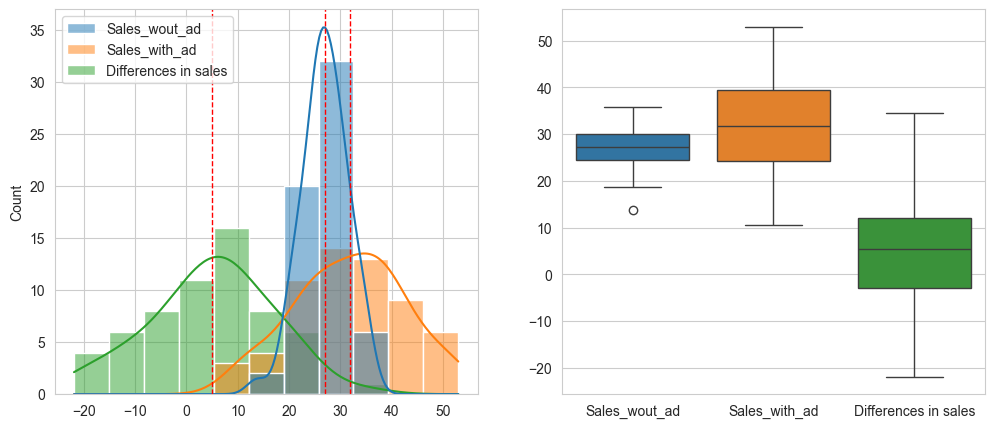

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.histplot(data=df, kde=True, ax=axes[0])
for col in df.columns:
    axes[0].axvline(df[col].mean(), color='r', linestyle='dashed', linewidth=1)
sns.boxplot(data=df, ax=axes[1])
plt.show()

## Conduct one-sided t-test on differences in sales
Null hypothesis: mean difference = 0 (no effect)
Alternative hypothesis: mean difference > 0 (ad increases sales)

In [7]:
test_res = pg.ttest(x=df['Differences in sales'], y=0, alternative='greater')
print("Full T-test result:")
print(test_res)

p_val = test_res.loc['T-test', 'p-val']
print(f"\nExtracted p-value: {p_val}")

Full T-test result:
               T  dof alternative     p-val        CI95%   cohen-d    BF10  \
T-test  3.169288   59     greater  0.001211  [2.32, inf]  0.409153  24.303   

           power  
T-test  0.931594  

Extracted p-value: 0.0012112174725460046


## Calculate 95% confidence interval for mean difference (two-sided test)

In [8]:
mean_diff = df['Differences in sales'].mean()
ci_95 = pg.ttest(x=df['Differences in sales'], y=0).loc['T-test', 'CI95%']
print(f"Mean difference in sales: {mean_diff}")
print(f"95% confidence interval for difference: {ci_95}")

Mean difference in sales: 4.917012259216051
95% confidence interval for difference: [1.81 8.02]


## Conclusion based on p-value and confidence interval
- p-value < 0.05, so reject null hypothesis
- Ads statistically increase sales by ~4.9 toys/day on average
- 95% CI indicates increase is between 1.81 and 8.02 toys/day

## Economic analysis
- Price per toy = $10
- Ad cost = $1500 per month (30 days)
- Calculate additional revenue and net gain/loss

In [9]:
price_per_toy = 10
ad_cost_month = 1500
days_per_month = 30

additional_daily_sales = mean_diff
additional_daily_revenue = additional_daily_sales * price_per_toy
monthly_additional_revenue = additional_daily_revenue * days_per_month
net_monthly_gain_loss = monthly_additional_revenue - ad_cost_month

print(f"Additional daily sales (mean): {additional_daily_sales:.2f} toys")
print(f"Additional daily revenue: ${additional_daily_revenue:.2f}")
print(f"Monthly additional revenue: ${monthly_additional_revenue:.2f}")
print(f"Monthly ad cost: ${ad_cost_month}")
print(f"Net monthly gain/loss: ${net_monthly_gain_loss:.2f}")

Additional daily sales (mean): 4.92 toys
Additional daily revenue: $49.17
Monthly additional revenue: $1475.10
Monthly ad cost: $1500
Net monthly gain/loss: $-24.90


## Summary:
- The ad statistically increases toy sales significantly.
- The monthly financial impact is slightly negative (~$24 loss).
- Consider long-term benefits like brand recognition and market share.
- Company may negotiate ad costs or explore other strategies.
